In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_collab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [4]:
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
    
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: {sys.executable}: command not found
/bin/bash: {sys.executable}: command not found
--2023-04-05 22:02:04--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg’

truck.jpg           100%[===================>] 265.11K  --.-KB/s    in 0.004s  

2023-04-05 22:02:05 (60.9 MB/s) - ‘images/truck.jpg’ saved [271475/271475]

--2023-04-05 22:02:05--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image and loading model

In [7]:
image = cv2.imread('/content/images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(1200, 1800, 3)

In [8]:
sam_checkpoint = "../sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

In [9]:
!git clone https://github.com/facebookresearch/segment-anything.git

Cloning into 'segment-anything'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 52 (delta 1), reused 0 (delta 0), pack-reused 38
Unpacking objects: 100% (52/52), 16.02 MiB | 3.36 MiB/s, done.


In [10]:
%cd /content/segment-anything

/content/segment-anything


In [11]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

# Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from ipywidgets import Output

%matplotlib ipympl

import matplotlib
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

output = Output()
display(output)

def onclick(event):
    if event.inaxes is not None:
        x, y = event.xdata, event.ydata
        with output:
            output.clear_output(wait=True)
            print("Clicked at x = {}, y = {}".format(x, y))
            input_point = np.array([[x,y]])
            poly = RegularPolygon(xy=(x, y), 
                                  numVertices=5, 
                                  radius=20, 
                                  orientation=np.pi/2, 
                                  facecolor='none', 
                                  edgecolor='r', 
                                  linewidth=2)
            ax.add_patch(poly)
            fig.canvas.draw_idle()

cid = fig.canvas.mpl_connect('button_press_event', onclick)



#CLIP POINTS using selective search 

- Next steps 
- points searching using Clip GradCAM


In [12]:
#@title Install dependencies

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

%%capture
!pip install ftfy regex tqdm matplotlib selectivesearch
!pip install git+https://github.com/openai/CLIP.git

import urllib.request
from collections import OrderedDict
import clip
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import selectivesearch
import torch
from PIL import Image

In [13]:
#@title Helper functions

#@markdown Some helper functions for loading, patchifying and visualizing images.

def load_image(img_path, resize=None, pil=False):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    if pil:
        return image
    image = np.asarray(image).astype(np.float32) / 255. 
    return image

# Reference: https://github.com/rbgirshick/fast-rcnn/blob/master/lib/utils/nms.py
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

# Reference: https://github.com/rbgirshick/py-faster-rcnn/blob/master/tools/demo.py
def vis_detections(im, dets, thresh=0.5, caption=None):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    top_idx = dets[:, -1].argmax()

    _, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red' if i == top_idx else 'green', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:.3f}'.format(score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    if caption is not None:
        plt.title(caption, fontsize=20)
    plt.show()


In [ ]:
#@title Generate Bounding Boxes with Selective Search

#@markdown If the cell takes too long to execute, it means the image size is too large.
#@markdown Use the resize parameter to reduce the image size, and rerun.

#@markdown ---

#@markdown #### Settings
image_url = '/content/images/truck.jpg' #@param {type:"string"}
resize = None#@param {type:"raw"}
topk = 50#@param {type:"integer"}
scale =  200#@param {type:"integer"}
sigma =  0.8#@param {type:"number"}
min_size = 50#@param {type:"integer"}

# Download the image from the web.
image_path =   image_url

# urllib.request.urlretrieve(image_url, image_path)

if resize is not None:
    assert isinstance(resize, int), "resize should be an integer."

img = load_image(image_path)
oh, ow = img.shape[:2]
print(f"Image resolution: {oh, ow}")

# Selective search.
img_search = load_image(image_path, resize=resize)
img_lbl, regions = selectivesearch.selective_search(
    img_search, scale=scale, sigma=sigma, min_size=min_size)
candidates = OrderedDict()
for i, r in enumerate(regions):
    if r['rect'] in candidates:
        continue
    if r['size'] < 1000:
        continue
    x, y, w, h = r['rect']
    if w / h > 1.5 or h / w > 1.5:
        continue
    if resize is not None:
        sx = (ow / resize)
        sy = (oh / resize)
        x_, y_, w_, h_ = r['rect']
        x = np.clip(x_ * sx, 0, ow).astype(int)
        y = np.clip(y_ * sy, 0, oh).astype(int)
        w = np.clip(w_ * sx, 0, ow).astype(int)
        h = np.clip(h_ * sy, 0, oh).astype(int)
        r['rect'] = (x, y, w, h)
    candidates[i] = r['rect']
candidates = list(candidates.values())
print(f"Generated {len(candidates)} bounding boxes. Taking the top {topk}.")
candidates = candidates[:topk]

# Display topk bounding boxes.
_, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
ax.imshow(img)
for x, y, w, h in candidates:
    rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
plt.show()

In [ ]:
#@title Detect

clip_model = "ViT-B/32" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
image_caption = 'the car side mirror' #@param {type:"string"}
nms_threshold =  0.1#@param {type:"number"}
viz_threshold = 0.2#@param {type:"number"}

# Load CLIP model.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model, preprocess = clip.load(clip_model, device=device, jit=False)

batch = []
for box in candidates:
    x, y, w, h = box
    patch = (img[y:y+h, x:x+w] * 255.).astype(np.uint8)
    patch = Image.fromarray(patch).convert("RGB")
    patch = preprocess(patch).unsqueeze(0)
    batch.append(patch)
batch = torch.cat(batch, dim=0).to(device)

image_caption = image_caption.split(';')
image_caption = [i for i in image_caption if i != '']
text_input = clip.tokenize(image_caption).to(device)

with torch.no_grad():
    patch_embs = model.encode_image(batch).float()
    text_embs = model.encode_text(text_input).float()
    patch_embs = patch_embs / patch_embs.norm(dim=-1, keepdim=True)
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
    sim = patch_embs @ text_embs.t()
scores = sim.cpu().numpy()

for caption, score in zip(image_caption, scores.T):
    dets = []
    for box, score in zip(candidates, score):
        x, y, w, h = box
        x1 = x
        x2 = x1 + w
        y1 = y
        y2 = y1 + h
        dets.append([x1, y1, x2, y2, score])
    dets = np.asarray(dets)
    keep = nms(dets, nms_threshold)
    dets_keep = dets[keep]

    vis_detections(img, dets_keep, thresh=viz_threshold, caption=caption)

In [ ]:
dets_keep.shape

In [17]:


import numpy as np

# Define the array with the corner coordinates
arr = dets_keep[0][0:4]
# Reshape the array to a 2x2 matrix, where each row represents a corner coordinate
corners = arr.reshape((2, 2))

# Calculate the center of the square as the average of the corner coordinates
input_point = np.array([corners.mean(axis=0)])

print(input_point)


[[1252.   379.5]]


# CLIP points using grad cam


In [24]:
#@title Install dependencies

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

%%capture
!pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
!pip install git+https://github.com/openai/CLIP.git

import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn


In [30]:
#@title Helper functions

#@markdown Some helper functions for loading, patchifying and visualizing images.
import math
import urllib.request
import clip
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
def load_image(img_path, resize=None, pil=False):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    if pil:
        return image
    return np.asarray(image).astype(np.float32) / 255.

def viz_patches(x, figsize=(20, 20), patch_idx=None, topk=None, t=5):
    # x: num_patches, 3, patch_size, patch_size
    n = x.shape[0]
    nrows = int(math.sqrt(n))
    _, axes = plt.subplots(nrows, nrows, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):            
        im = x[i].permute(1, 2, 0).numpy()
        im = (im * 255.).round().astype(np.uint8)
        if patch_idx is not None and i == patch_idx:
            im[0:t] = (255, 0, 0)
            im[im.shape[0]-t:] = (255, 0, 0)
            im[:, 0:t] = (255, 0, 0)
            im[:, im.shape[1]-t:] = (255, 0, 0)
        if topk is not None:
            if i in topk and i != patch_idx:
                im[0:t] = (255, 255, 0)
                im[im.shape[0]-t:] = (255, 255, 0)
                im[:, 0:t] = (255, 255, 0)
                im[:, im.shape[1]-t:] = (255, 255, 0)
        ax.imshow(im)
        ax.axis("off")
    plt.show()

def patchify(image_path, resolution, patch_size, patch_stride=None):
    img_tensor = transforms.ToTensor()(load_image(image_path, resolution, True))
    if patch_stride is None:
        patch_stride = patch_size
    patches = img_tensor.unfold(
        1, patch_size, patch_stride).unfold(2, patch_size, patch_stride)
    patches = patches.reshape(3, -1, patch_size, patch_size).permute(1, 0, 2, 3)
    return patches  # N, 3, patch_size, patch_size


##sliding window

In [119]:
from torchvision import transforms
from PIL import Image 
# transform the image into tensor
transt = transforms.ToTensor()
image = Image.open("/content/images/groceries.jpg")
img = transt(image)
img.data.shape

torch.Size([3, 534, 800])

In [120]:
# add batch dimension and shift color channels
patches = img.data.unfold(0,3,3)
patches.shape

torch.Size([1, 534, 800, 3])

Adjust the patch size as per object average size to detect

In [ ]:
patch = 128


In [121]:
# break the image into patches (in height dimension)





patches = patches.unfold(1, patch, patch)
patches.shape

torch.Size([1, 4, 800, 3, 128])

In [122]:
# break the image into patches (in width dimension)
patches = patches.unfold(2, patch, patch)
patches.shape

torch.Size([1, 4, 6, 3, 128, 128])

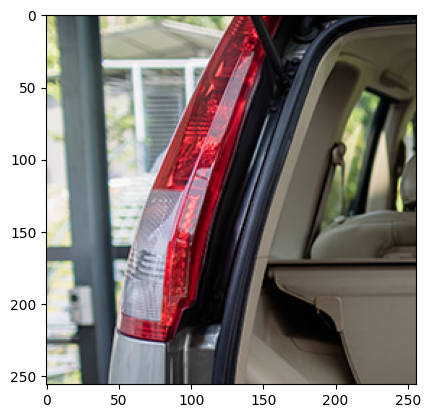

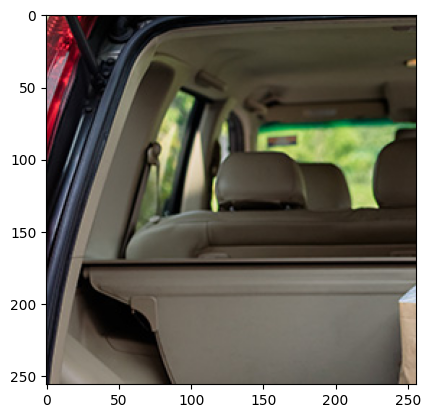

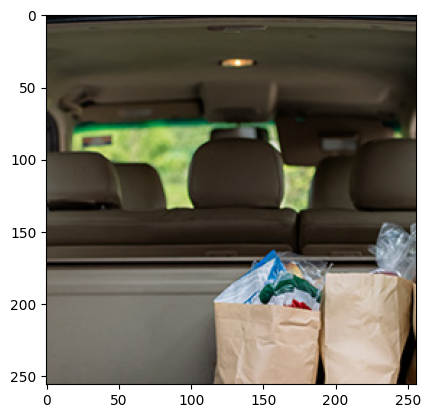

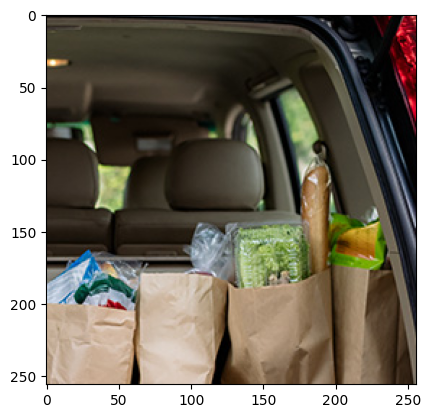

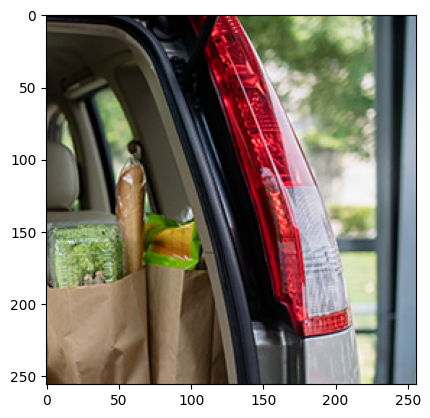

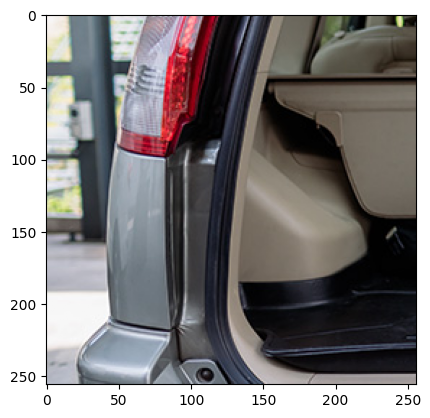

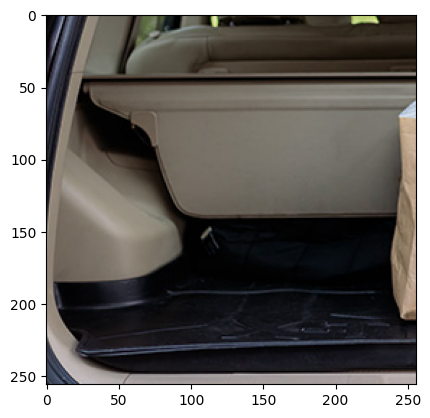

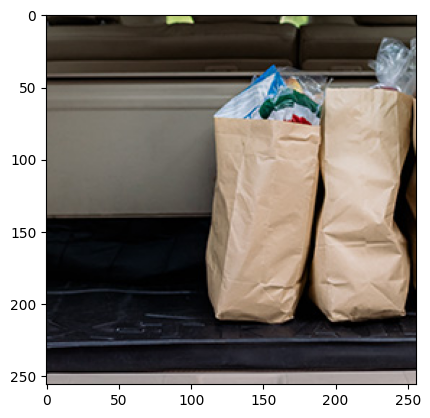

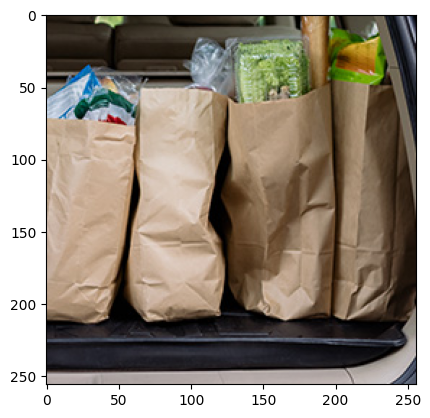

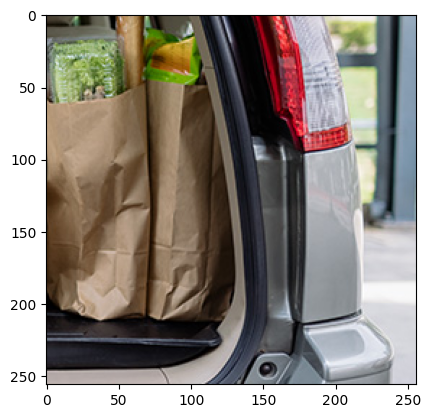

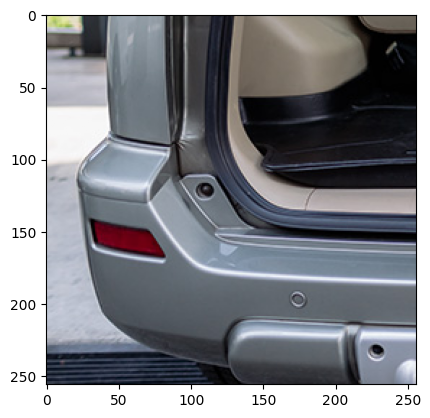

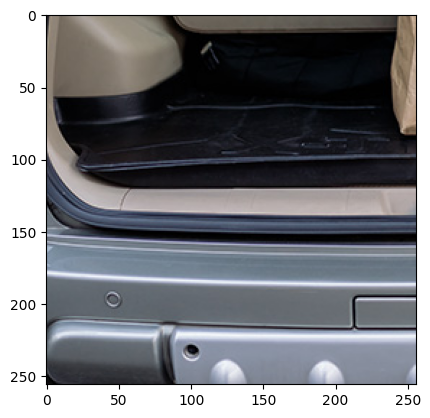

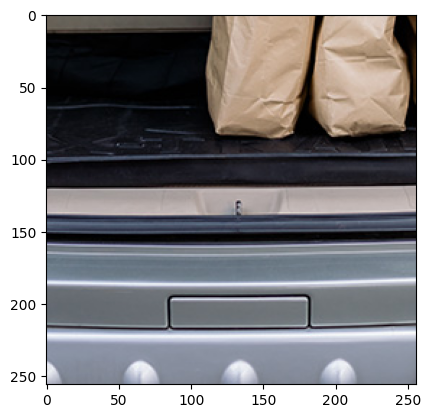

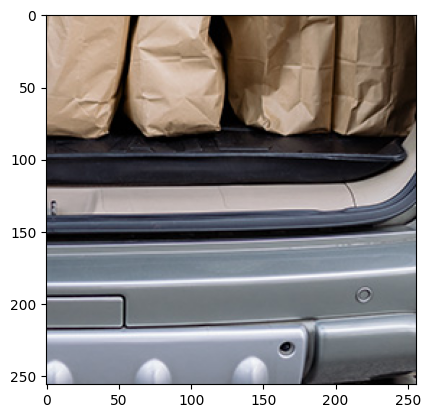

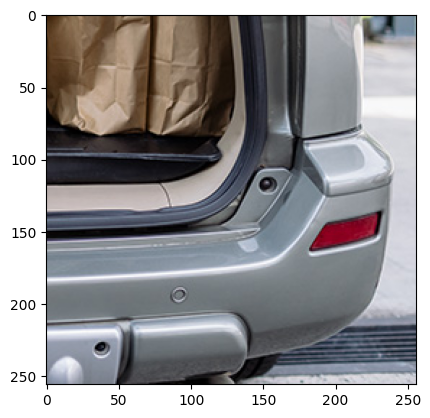

In [123]:

window = 2
stride = 1
# window slides from top to bottom
for Y in range(0, patches.shape[1]-window+1, stride):
    # window slides from left to right
    for X in range(0, patches.shape[2]-window+1, stride):
        # initialize an empty big_patch array
        big_patch = torch.zeros(patch*window, patch*window, 3)
        # this gets the current batch of patches that will make big_batch
        patch_batch = patches[0, Y:Y+window, X:X+window]
        # loop through each patch in current batch
        for y in range(patch_batch.shape[1]):
            for x in range(patch_batch.shape[0]):
                # add patch to big_patch
                big_patch[
                    y*patch:(y+1)*patch, x*patch:(x+1)*patch, :
                ] = patch_batch[y, x].permute(1, 2, 0)
        # display current big_patch
        plt.imshow(big_patch)
        plt.show()

In [ ]:
!pip install transformers
from transformers import CLIPProcessor, CLIPModel
import torch

# define processor and model
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

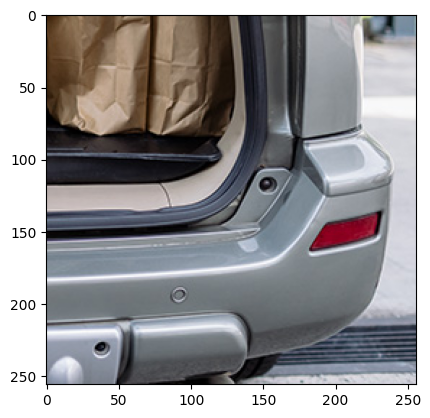

22.69312858581543


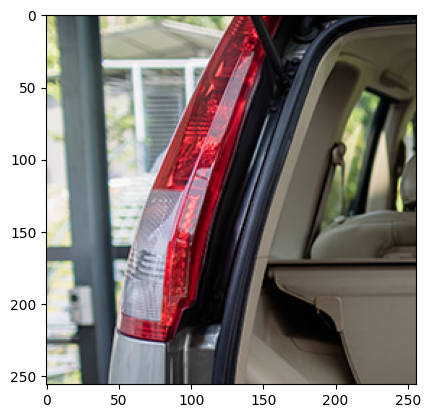

20.665416717529297


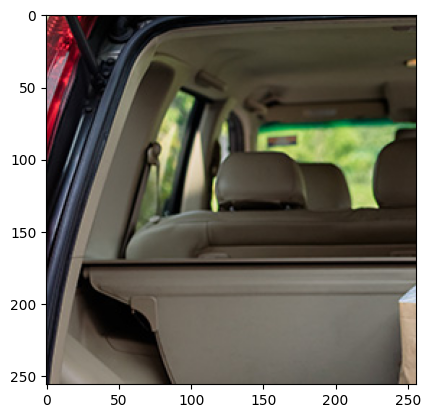

20.368921279907227


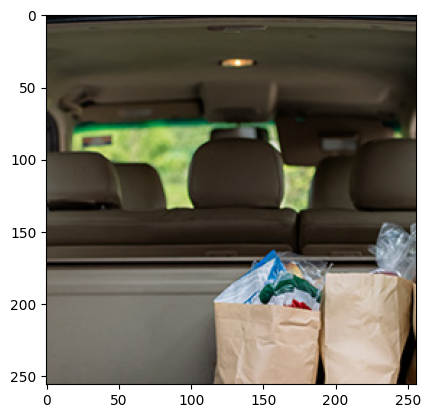

18.30181121826172


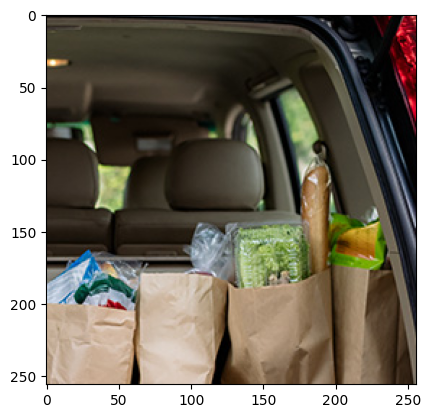

19.74321174621582


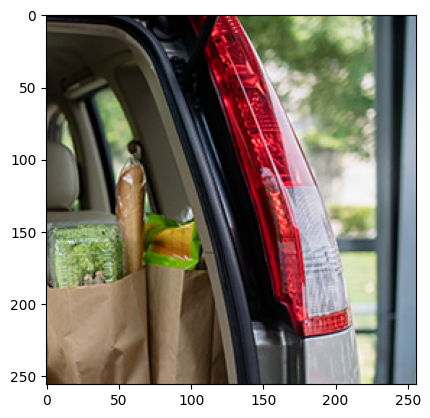

21.423250198364258


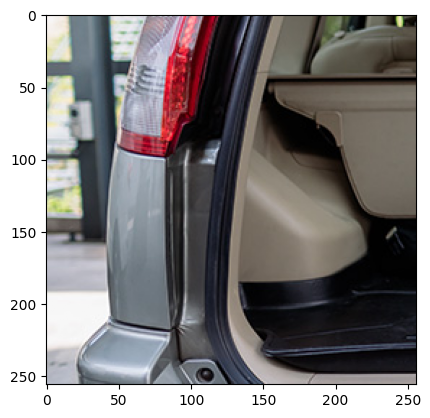

19.990203857421875


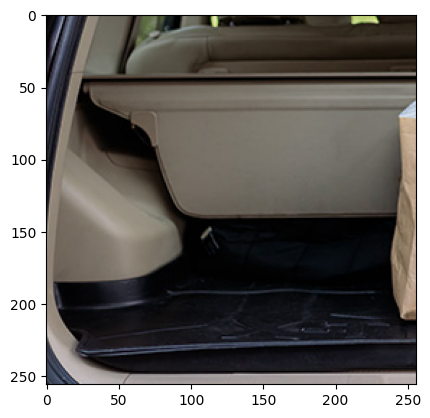

16.898698806762695


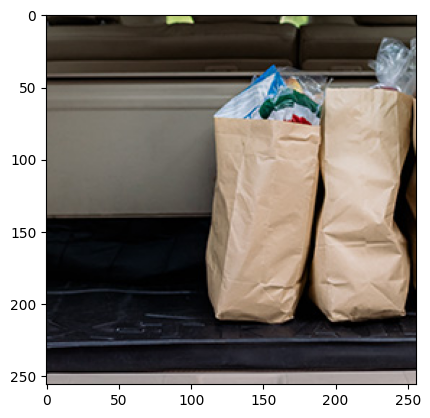

18.67918586730957


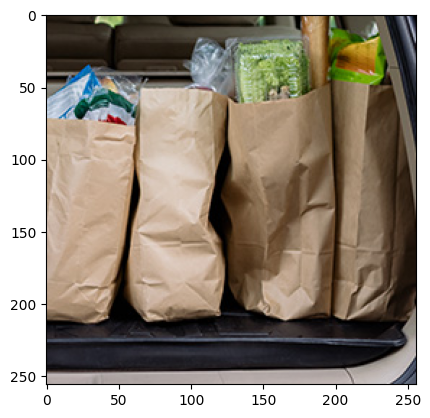

19.595218658447266


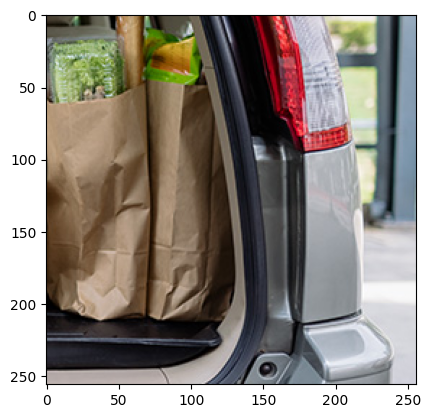

21.55143928527832


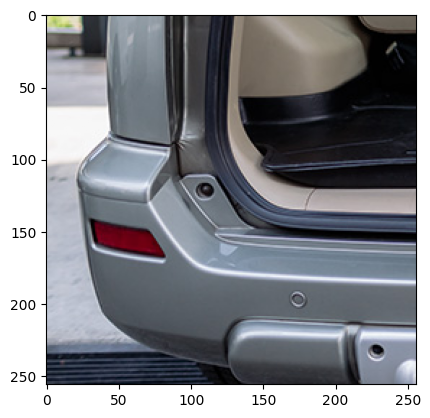

21.460403442382812


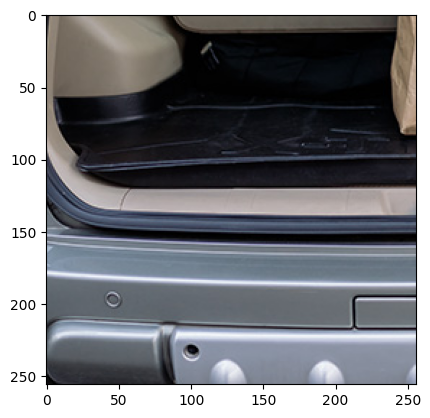

21.515148162841797


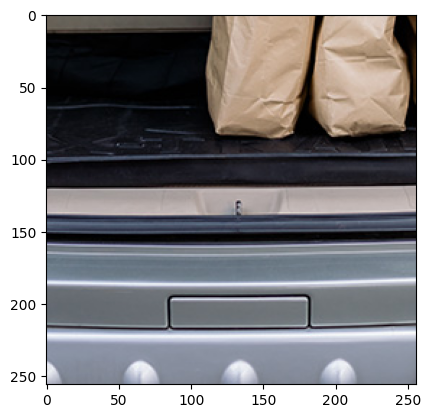

22.173757553100586


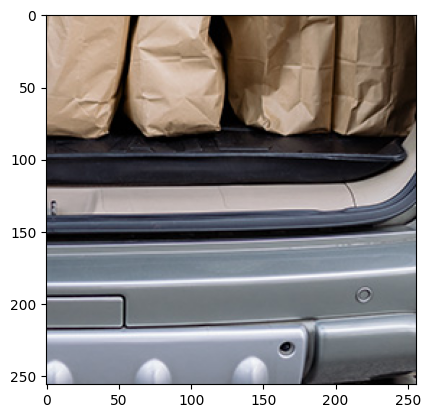

21.447641372680664


In [129]:
# window = 3
# stride = 1

scores = torch.zeros(patches.shape[1], patches.shape[2])
runs = torch.ones(patches.shape[1], patches.shape[2])
image_patch_list = [];score_list = []
for Y in range(0, patches.shape[1]-window+1, stride):
    for X in range(0, patches.shape[2]-window+1, stride):
        plt.imshow(big_patch)
        plt.show()
        image_patch_list.append(big_patch)
        big_patch = torch.zeros(patch*window, patch*window, 3)
        patch_batch = patches[0, Y:Y+window, X:X+window]
        for y in range(window):
            for x in range(window):
                big_patch[
                    y*patch:(y+1)*patch, x*patch:(x+1)*patch, :
                ] = patch_batch[y, x].permute(1, 2, 0)
        # we preprocess the image and class label with the CLIP processor
        inputs = processor(
            images=big_patch,  # big patch image sent to CLIP
            return_tensors="pt",  # tell CLIP to return pytorch tensor
            text="car turn signals or blinkers",  # class label sent to CLIP
            padding=True
        ).to(device) # move to device if possible

        # calculate and retrieve similarity score
        score = model(**inputs).logits_per_image.item()
        print(score)
        score_list.append(score)
        # sum up similarity scores from current and previous big patches
        # that were calculated for patches within the current window
        scores[Y:Y+window, X:X+window] += score
        # calculate the number of runs on each patch within the current window
        runs[Y:Y+window, X:X+window] += 1

15


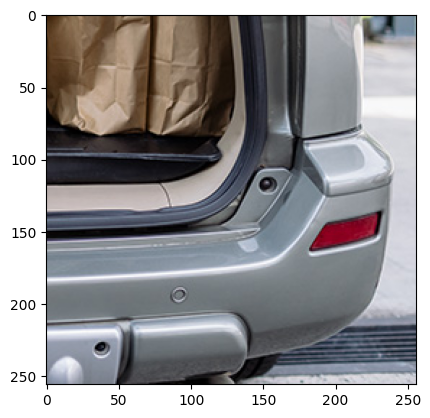

In [150]:
print(len(image_patch_list))
plt.imshow(image_patch_list[np.argmax(np.array(score_list))])
plt.savefig("/content/patch_best.jpg")




##explainability

In [131]:
#@title Helper functions

#@markdown Some helper functions for overlaying heatmaps on top
#@markdown of images and visualizing with matplotlib.

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()
    
def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.


In [132]:
#@title GradCAM: Gradient-weighted Class Activation Mapping

#@markdown Our gradCAM implementation registers a forward hook
#@markdown on the model at the specified layer. This allows us
#@markdown to save the intermediate activations and gradients
#@markdown at that layer.

#@markdown To visualize which parts of the image activate for
#@markdown a given caption, we use the caption as the target
#@markdown label and backprop through the network using the
#@markdown image as the input.
#@markdown In the case of CLIP models with resnet encoders,
#@markdown we save the activation and gradients at the
#@markdown layer before the attention pool, i.e., layer4.

class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()
        
    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)
        
    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:        
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()
    
        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)
    
    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])
        
    return gradcam


!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

In [136]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [137]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [138]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1: 
      # calculate index of last layer 
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [139]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [140]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [141]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [142]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [143]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

tensor([0.3123, 0.0668, 0.0467, 0.1045, 0.0689, 0.4009], device='cuda:0',
       dtype=torch.float16)


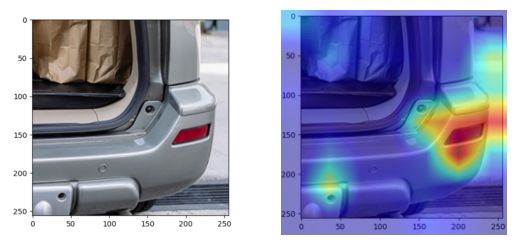

In [146]:
img_path = "/content/vv.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["car turn signals or blinkers"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

#Set point


In [ ]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [ ]:

input_label = np.array([1])

In [ ]:
%matplotlib inline


plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

# visualize results with SAM


In [ ]:
masks.shape  # (number_of_masks) x H x W

In [ ]:
%matplotlib inline

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

# Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
input_point = np.array([[272,322],[274,327]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
masks.shape

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

To exclude the car and specify just the window, a background point (with label 0, here shown in red) can be supplied.

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [ ]:
input_box = np.array([425, 600, 700, 875])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Combining points and boxes

Points and boxes may be combined, just by including both types of prompts to the predictor. Here this can be used to select just the trucks's tire, instead of the entire wheel.

In [ ]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Batched prompt inputs

SamPredictor can take multiple input prompts for the same image, using `predict_torch` method. This method assumes input points are already torch tensors and have already been transformed to the input frame. For example, imagine we have several box outputs from an object detector.

In [ ]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

Transform the boxes to the input frame, then predict masks. `SamPredictor` stores the necessary transform as the `transform` field for easy access, though it can also be instantiated directly for use in e.g. a dataloader (see `segment_anything.utils.transforms`).

In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [ ]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## End-to-end batched inference

If all prompts are available in advance, it is possible to run SAM directly in an end-to-end fashion. This also allows batching over images.

In [ ]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

Both images and prompts are input as PyTorch tensors that are already transformed to the correct frame. Inputs are packaged as a list over images, which each element is a dict that takes the following keys:
* `image`: The input image as a PyTorch tensor in CHW format.
* `original_size`: The size of the image before transforming for input to SAM, in (H, W) format.
* `point_coords`: Batched coordinates of point prompts.
* `point_labels`: Batched labels of point prompts.
* `boxes`: Batched input boxes.
* `mask_inputs`: Batched input masks.

If a prompt is not present, the key can be excluded.

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device) 
    return image.permute(2, 0, 1).contiguous()

In [ ]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

Run the model.

In [ ]:
batched_output = sam(batched_input, multimask_output=False)

The output is a list over results for each input image, where list elements are dictionaries with the following keys:
* `masks`: A batched torch tensor of predicted binary masks, the size of the original image.
* `iou_predictions`: The model's prediction of the quality for each mask.
* `low_res_logits`: Low res logits for each mask, which can be passed back to the model as mask input on a later iteration.

In [ ]:
batched_output[0].keys()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()